In [51]:
import json
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sklearn.neighbors as nb

In [52]:
dataset_path = "../datasets/UrbanVehicle"

## Load road graph
road_graph: nx.DiGraph
with open("road_graph_nsl_sc.pickle", mode="rb") as file:
    road_graph = pickle.load(file)

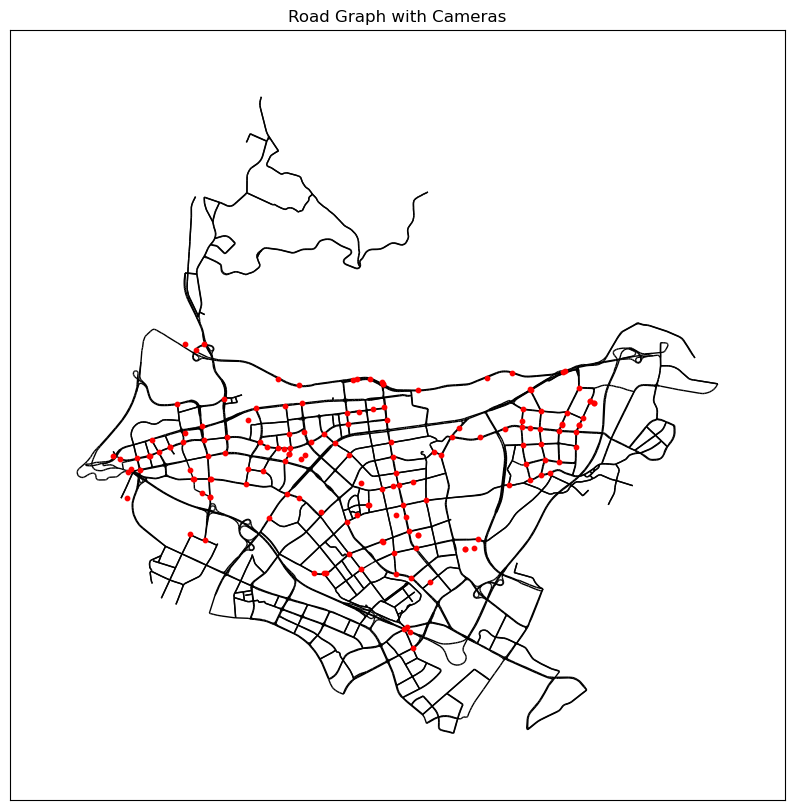

In [53]:
## Load cameras
cameras = list()
with open(f"{dataset_path}/cameras.json", mode="r", encoding="utf-8") as file:
    for line in file:
        camera = json.loads(line)
        cameras.append({"camera_id": camera["camera_id"], "x": camera["position"][0], "y": camera["position"][1]})

camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])

## Draw cameras on road graph
pos = nx.get_node_attributes(road_graph, "pos")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)
ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=10, c="red")
ax.set_title("Road Graph with Cameras")
plt.show()

In [54]:
## Match cameras to nearest node
nodes = [{"node_id": node[0], "x": node[1]["pos"][0], "y": node[1]["pos"][1]} for node in road_graph.nodes(data=True)]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

tree = nb.KDTree(node_coordinates)
indices = tree.query(camera_coordinates, k=1, return_distance=False)
indices = indices.flatten()

for index, camera in zip(indices, cameras):
    camera["node_id"] = nodes[index]["node_id"]

In [55]:
## Assign records to cameras
cameras_dict = {camera["camera_id"]: camera for camera in cameras}

with open(f"{dataset_path}/records/records.json", mode="r", encoding="utf-8") as file:
    for line in file:
        record = json.loads(line)
        camera = cameras_dict[record["camera_id"]]
        if "records" in camera:
            camera["records"] += 1
        else:
            camera["records"] = 1

# Camera Info format:
# {
#   camera_id: {
#       "camera_id": int,       Camera ID
#       "x": float,             X coordinate
#       "y": float,             Y coordinate
#       "node_id": int,         Nearest node
#       "records": int          Number of records
#   }
# }

# Save camera info
with open("cameras_info.pickle", mode="wb") as file:
    pickle.dump(cameras_dict, file)